In [1]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers import LeakyReLU
from keras.layers import UpSampling2D, Conv2D
from keras.models import Model, save_model, load_model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import datetime, sys, os, cv2, warnings
warnings.filterwarnings('ignore')

from DataGenerator import DataGenerator

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/세미(2) 프로젝트/NEWDATA/GAN/evee

/content/drive/.shortcut-targets-by-id/1iZJ97_6lEv6dD796nV-fw4WzH5bf62Jz/세미(2) 프로젝트/NEWDATA/GAN/evee


In [9]:
class Pix2Pix():
    def __init__(self):
        self.img_rows = 128
        self.img_cols = 128
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        self.data_loader = DataGenerator()

        # calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)

        # number of filters in the first layer of G and D
        self.gf = 128
        self.df = 128

        # build discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(
            loss='mse',
            optimizer='adam',
            metrics=['accuracy']
        )

        # build generator
        self.generator = self.build_generator()

        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        fake_B = self.generator(img_A)

        # do not train discriminator while training generator
        self.discriminator.trainable = False

        valid = self.discriminator([img_A, fake_B])

        self.combined = Model(inputs=[img_A, img_B], outputs=[valid, fake_B])
        self.combined.compile(
            loss=['mse', 'mae'],
            loss_weights=[1, 100],
            optimizer='adam'
        )

    def build_generator(self):
        def conv2d(layer_input, filters, kernel_size=4, bn=True):
            d = Conv2D(filters, kernel_size=kernel_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        def deconv2d(layer_input, skip_input, filters, kernel_size=4, dropout_rate=0):
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = BatchNormalization(momentum=0.8)(u)
            # print(u.shape,'\t',skip_input.shape)        # shape 확인용
            if skip_input.shape[-2] < u.shape[-2]:
                skip_input = UpSampling2D(size=2)(skip_input)
            u = Concatenate()([u, skip_input])
            return u

        # image input
        d0 = Input(shape=self.img_shape)

        # downsampling
        d1 = conv2d(d0, self.gf, bn=False)
        d2 = conv2d(d1, self.gf*2)
        d3 = conv2d(d2, self.gf*4)
        d4 = conv2d(d3, self.gf*8)
        d5 = conv2d(d4, self.gf*8)
        d6 = conv2d(d5, self.gf*8)

        # upsampling
        u1 = deconv2d(d6, d5, self.gf*8)
        u2 = deconv2d(u1, d4, self.gf*8)
        u3 = deconv2d(u2, d3, self.gf*8)
        u4 = deconv2d(u3, d2, self.gf*4)
        u5 = deconv2d(u4, d1, self.gf*2)
        #u6 = deconv2d(u5, d1, self.gf)

        u6 = UpSampling2D(size=2)(u5)

        output_img = Conv2D(self.channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u6)

        return Model(d0, output_img)

    def build_discriminator(self):

        def d_layer(layer_input, filters, kernel_size=4, bn=True):
            d = Conv2D(filters, kernel_size=kernel_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        combined_imgs = Concatenate(axis=-1)([img_A, img_B])

        d1 = d_layer(combined_imgs, self.df, bn=False)
        d2 = d_layer(d1, self.df*1)
        d3 = d_layer(d2, self.df*2)
        d4 = d_layer(d3, self.df*4)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model([img_A, img_B], validity)

    def train(self, epochs, batch_size=1, sample_interval=50):
        
        # adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)

        loss_min = 100
        acc = 0

        for epoch in range(epochs):
            print('[Epoch %d/%d]' % (epoch+1, epochs), end = '\t')
            start_time =  datetime.datetime.now()
            
            for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):
                # ---------------------
                #  Train Discriminator
                # ---------------------
                fake_B = self.generator.predict(imgs_A)

                if np.random.random() < 0.5:
                    d_loss = self.discriminator.train_on_batch([imgs_A, imgs_B], valid)
                else:
                    d_loss = self.discriminator.train_on_batch([imgs_A, fake_B], fake)
                # d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                # -----------------
                #  Train Generator
                # -----------------
                g_loss = self.combined.train_on_batch([imgs_A, imgs_B], [valid, imgs_B])

                # save sample images
                if batch_i % sample_interval == 0:
                    self.sample_images(epoch, batch_i, d_loss)

                # save sample images when discriminator has low accuracy
                if epoch > 9 and d_loss[1] < 0.6:
                    self.sample_images(epoch, batch_i, d_loss, low=True)
                
            # print
            elapsed_time = datetime.datetime.now() - start_time
            print('[D loss: %f, acc: %3d%%] [G loss: %f] time: %s' % (d_loss[0], 100*d_loss[1], g_loss[0], elapsed_time))
            
            if d_loss[0] <= loss_min and d_loss[1] >= acc :
                loss_min = d_loss[0]
                acc = d_loss[1]
                save_model(self.generator, 'best_line2gray_eevee_20.h5')
                print('<< save model complete >>')

    def sample_images(self, epoch, batch_i, d_loss, low=False):
        os.makedirs('samples20', exist_ok=True)

        imgs_A, imgs_B = self.data_loader.load_data(batch_size=3, is_train=False)
        fake_B = self.generator.predict(imgs_A)

        gen_imgs = np.concatenate([imgs_A, fake_B, imgs_B])

        # rescale images to 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Input', 'Generated', 'Ground Truth']
        fig, axs = plt.subplots(3, 3)

        for i in range(3):
            for j in range(3):
                axs[i, j].imshow(gen_imgs[3*i+j].squeeze(), cmap='gray')
                axs[i, j].set_title(titles[i])
                axs[i, j].axis('off')

        if not low:
            fig.savefig('samples20/%d_%d_%d.png' % (epoch, batch_i, d_loss[1] * 100))
        plt.close()

if __name__ == '__main__':
    gan = Pix2Pix()
    gan.train(epochs=20, batch_size=1, sample_interval=1000)

[Epoch 1/20]	[D loss: 0.220487, acc:  79%] [G loss: 40.340530] time: 0:00:43.512104
<< save model complete >>
[Epoch 2/20]	[D loss: 0.254392, acc:  73%] [G loss: 51.074398] time: 0:00:42.161513
[Epoch 3/20]	[D loss: 0.381067, acc:  48%] [G loss: 37.368378] time: 0:00:41.897794
[Epoch 4/20]	[D loss: 0.331395, acc:  73%] [G loss: 31.971197] time: 0:00:41.745944
[Epoch 5/20]	[D loss: 0.446943, acc:  62%] [G loss: 31.166227] time: 0:00:41.615527
[Epoch 6/20]	[D loss: 0.333183, acc:  43%] [G loss: 24.562122] time: 0:00:41.450851
[Epoch 7/20]	[D loss: 0.199775, acc:  75%] [G loss: 22.558279] time: 0:00:41.628013
[Epoch 8/20]	[D loss: 0.296542, acc:  57%] [G loss: 17.022072] time: 0:00:41.429891
[Epoch 9/20]	[D loss: 0.190657, acc:  76%] [G loss: 18.632004] time: 0:00:41.514255
[Epoch 10/20]	[D loss: 0.397801, acc:  56%] [G loss: 20.501881] time: 0:00:41.634995
[Epoch 11/20]	[D loss: 0.365081, acc:  46%] [G loss: 16.361162] time: 0:01:08.828606
[Epoch 12/20]	[D loss: 0.475985, acc:  39%] [G l

In [10]:
save_model(gan.generator, 'total_line2gray_eevee_20.h5')

In [22]:
practice20 = load_model('total_line2gray_eevee_20.h5')
practice20.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

practice30 = load_model('total_line2gray_eevee_30.h5')
practice30.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

practice50 = load_model('total_line2gray_eevee_50.h5')
practice50.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

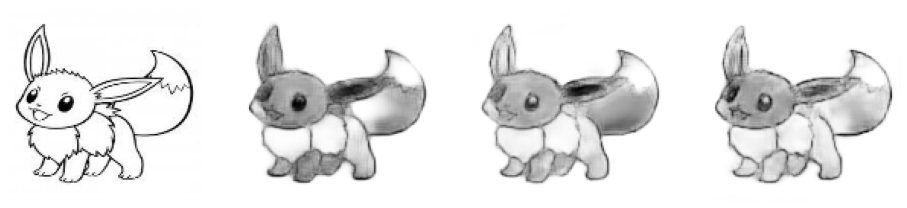

In [25]:
img = cv2.imread('eevee2.jpg')
img = cv2.resize(img, dsize=(128, 128), interpolation= cv2.INTER_LINEAR)

img_edges = []
edges = cv2.Canny(img, 150, 200)
img_edges.append(np.expand_dims(edges, axis=-1))
img_edges = np.array(img_edges) / 127.5 -1

pred_20 = practice20.predict(img_edges)
pred_30 = practice30.predict(img_edges)
pred_50= practice50.predict(img_edges)

plt.figure(figsize = (16, 4))

plt.subplot(1, 4, 1)
plt.axis('off')
plt.imshow(img)

plt.subplot(1, 4, 2)
plt.axis('off')
plt.imshow(pred_20.reshape(128, 128), cmap = 'gray')

plt.subplot(1, 4, 3)
plt.axis('off')
plt.imshow(pred_30.reshape(128, 128), cmap = 'gray');

plt.subplot(1, 4, 4)
plt.axis('off')
plt.imshow(pred_50.reshape(128, 128), cmap = 'gray');

In [26]:
plt.imsave('eevee_pre_20.jpg', pred_20.reshape(128, 128), cmap = 'gray')
plt.imsave('eevee_pre_30.jpg', pred_30.reshape(128, 128), cmap = 'gray')
plt.imsave('eevee_pre_50.jpg', pred_50.reshape(128, 128), cmap = 'gray')
#plt.imsave('pie_pred2.jpg', pred_total.reshape(128, 128), cmap = 'gray')